# 2950 Project Phase 2

Flavia Jiang (yj472), Rachel Wang (jw879)

## Research Question

## Data Description

1.What are the observations (rows) and the attributes (columns)?


2. Why was this dataset created?
This dataset was created to investigate and analyze various aspects of human dating behavior in the context of speed dating. 
Researchers were interested in understanding how individuals(males and females) make dating decisions, what attributes they 
consider important, and how different factors influence the outcomes of speed dating encounters.

3. Who funded the creation of the dataset?

The dataset was collected as part of academic research. 

4. What processes might have influenced what data was observed and recorded and what was not?

Participant Demographics: The age, gender, and demographic characteristics of the participants could influence the data collected. 
In this study, all subjects are from graduate and professional school of Columbia University.

Self-Selection of Participants: Participants in the speed dating experiment were volunteers, which means they self-selected to take part. 
This self-selection process may have introduced biases, as those who chose to participate might have different preferences or characteristics 
compared to the general population. This could impact the generalizability of the findings.

Experiment Design: The design of the speed dating experiment determined what data could be collected. The researchers structured the experiment, 
including the number of participants, the number of potential partners, and the available information about each partner. The experimental 
conditions may not fully represent real-world dating situations.

Survey Responses: The data collected was based on surveys and questionnaires filled out by participants. Data collection relied on participants' 
willingness to respond honestly and accurately, which could be influenced by social desirability bias or other factors.

5. What preprocessing was done, and how did the data come to be in the form that you are using?


6. If people are involved, were they aware of the data collection, and if so, what purpose did they expect the data to be used for?

Participants in the speed dating events would have been aware of the data collection process, as informed consent is a standard practice 
in research involving human subjects. They would have been informed about the purpose of the data collection, which is typically for academic 
research. Participants would have expected the data to be used to study dating behavior and potentially contribute to our understanding of human 
interactions and preferences.

7. Where can your raw source data be found, if applicable? Provide a link to the raw data

Link to the dataset and the documentation: http://www.stat.columbia.edu/~gelman/arm/examples/speed.dating/ 


## Data Cleaning

In [862]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb

Firstly, load the data. The data set is wide and long, with 8378 rows and 195 columns.

In [863]:
dating_df = pd.read_csv("speed_dating_data.csv", encoding="ISO-8859-1")
dating_df.shape

(8378, 195)

### Select necessary columns
The data set is super wide, and there are so many variables. So we went through the codebook made by the creators of this data set and selected variables we currently think would be necessary for our future analysis. Now we still have 41 columns. 

Certainly, we won't use all of them at once in a logistic regression model. For example, demographic information about the participants such as the variables "age," "race," and "field" will be mainly used in descriptive statistics for us to know about the subject population and detect sampling bias of the study rather than using them as explanatory variables in the model.

In [864]:
select_list = ['iid', 'gender', 'wave', 'round', 'pid', 'samerace', 'age_o', 'age', 'field_cd', 
               'race','career_c', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 
               'hiking', 'gaming', 'clubbing', 'reading', 'tv','theater', 'movies', 'concerts', 
               'music', 'shopping', 'yoga', 'attr3_1','sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1', 
               'dec', 'attr', 'sinc','intel', 'fun', 'amb', 'shar', 'prob']

dating_df = dating_df[select_list]
dating_df.shape

(8378, 41)

### Rename columns

Though we did not do any web scraping or merge data sets to get this data frame, one main effort we made was to interpret the meaning of each variable – carefully reading through the 15-paged codebook. We noticed that some of the names of the given variable names were vague. So, we decided to change them so they conveyed more straightforward information about the variables. 

In [865]:
dating_df = dating_df.rename(columns = {"iid":"id",
                                        "age_o":"partner_age",
                                        "round": "num_dates", 
                                        "pid": "partner_id", 
                                        "samerace": "same_race", 
                                        "dec": "decision",
                                        "attr3_1": "rate_self_attr", 
                                        "sinc3_1": "rate_self_sinc",
                                        "fun3_1": "rate_self_fun",
                                        "intel3_1": "rate_self_intel",
                                        "amb3_1": "rate_self_amb",
                                        "attr": "rate_p_attr",
                                        "sinc": "rate_p_sinc",
                                        "fun": "rate_p_fun",
                                        "intel": "rate_p_intel",
                                        "amb": "rate_p_amb",
                                        "shar": "rate_p_shar"})
dating_df.columns

Index(['id', 'gender', 'wave', 'num_dates', 'partner_id', 'same_race',
       'partner_age', 'age', 'field_cd', 'race', 'career_c', 'sports',
       'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
       'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music',
       'shopping', 'yoga', 'rate_self_attr', 'rate_self_sinc', 'rate_self_fun',
       'rate_self_intel', 'rate_self_amb', 'decision', 'rate_p_attr',
       'rate_p_sinc', 'rate_p_intel', 'rate_p_fun', 'rate_p_amb',
       'rate_p_shar', 'prob'],
      dtype='object')

### Remove biased observations
As described in Data Description part, the researchers ran 21 speed dating sessions, or waves, in total. However, as they explained in their paper, they removed four sessions (waves 18-21) from the analysis "because they involved an experimental intervention where participants were asked to bring their favorite book. These four sessions were run specifically to study how decision weights and selectivity would be affected by an intervention designed to shift subjects’ attention away from superficial physical attributes. They are omitted so that the only experimental difference across sessions is group size." Accordingly we also removed data for these four sessions. 

The researchers also said they removed another wave (#12) because they "imposed a maximum number of acceptances" on participants of this wave. We thought this restriction would affect participants' decisions, so we also removed this wave.

In [866]:
dating_df = dating_df[~dating_df['wave'].isin([12, 18, 19, 20, 21])]
dating_df.shape

(6412, 41)

### Deal with missing values
We noticed there were many missing values due to how the experiment was designed and conducted. For each variable with more than 200 missing values, we re-examined whether we still thought it would be a potential good predictor in our future modeling given the fact that including it would mean fewer data points to train the model, which might make the model less robust. Finally we decided to remove the variable called "rate_p_shar," which was the dater's rating of shared interests/hobbies for the datee.

In [867]:
# count NAs for each column
for col in dating_df:
    n = sum(pd.isna(dating_df[col]))
    if (n > 0):
        print([col, n])

dating_df = dating_df.drop(["rate_p_shar"], axis = 1)

['partner_id', 10]
['partner_age', 82]
['age', 73]
['field_cd', 82]
['race', 63]
['career_c', 138]
['sports', 79]
['tvsports', 79]
['exercise', 79]
['dining', 79]
['museums', 79]
['art', 79]
['hiking', 79]
['gaming', 79]
['clubbing', 79]
['reading', 79]
['tv', 79]
['theater', 79]
['movies', 79]
['concerts', 79]
['music', 79]
['shopping', 79]
['yoga', 79]
['rate_self_attr', 105]
['rate_self_sinc', 105]
['rate_self_fun', 105]
['rate_self_intel', 105]
['rate_self_amb', 105]
['rate_p_attr', 130]
['rate_p_sinc', 196]
['rate_p_intel', 208]
['rate_p_fun', 260]
['rate_p_amb', 553]
['rate_p_shar', 874]
['prob', 206]


Next, let's see how many rows would be left if all rows with any missing values were dropped.

In [868]:
dating_df = dating_df.dropna()
dating_df.shape

(5493, 40)

From a statistical standpoint, a sample of 5493 datapoints would be good enough for logistic regression. We would also have enough for splitting it into training and testing sets.

### Map coded categorical variables to their corresponding values

Some categorical variables were coded as integers (e.g., gender, field, race, career). This was for data storage and system performance reasons. For our purposes, we thought it would be better if these variables were presented as the actual values rather than the integer codes so that we could visualize, analyze, and interpret them more efficiently. So we did the following conversion.

In [869]:
dating_df["field"] = dating_df["field_cd"].map({1:"Law", 2:"Math", 3:"Social Science, Psychologist", 
                                                4:"Medical Science, Pharmaceuticals, and Bio Tech", 
                                                5:"Engineering", 6:"English/Creative Writing/Journalism", 
                                                7:"History/Religion/Philosophy", 8:"Business/Econ/Finance", 
                                                9:"Education, Academia", 10:"Biological Sciences/Chemistry/Physics", 
                                                11:"Social Work", 12:"Undergrad/undecided", 
                                                13:"Political Science/International Affairs", 14:"Film", 
                                                15:"Fine Arts/Arts Administration", 16:"Languages", 
                                                17:"Architecture", 18:"Other"})
# drop the old column
dating_df = dating_df.drop(["field_cd"], axis=1)

dating_df["race"] = dating_df["race"].map({1: "Black/African American", 2:"European/Caucasian-American", 
                                           3:"Latino/Hispanic American", 4:"Asian/Pacific Islander/Asian-American", 
                                           5:"Native American", 6:"Other"})

dating_df["career"] = dating_df["career_c"].map({1:"Lawyer ", 2:"Academic/Research", 3:"Psychologist",4:"Doctor/Medicine",
                                                  5:"Engineer", 6:"Creative Arts/Entertainment", 
                                                  7:"Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin", 
                                                  8:"Real Estate", 9:"International/Humanitarian Affairs", 10:"Undecided", 
                                                  11:"Social Work", 12:"Speech Pathology", 13:"Politics", 14:"Pro sports/Athletics", 
                                                  15:"Other", 16:"Journalism", 17:"Architecture"})
# drop the old column
dating_df = dating_df.drop(["career_c"], axis=1)

dating_df["gender"] = dating_df["gender"].map({0:"Female", 1:"Male"})

# check that they were successfully updated
print(dating_df["field"].unique())
print(dating_df["race"].unique())
print(dating_df["career"].unique())
print(dating_df["gender"].unique())

['Law' 'Political Science/International Affairs' 'Business/Econ/Finance'
 'Engineering' 'Education, Academia' 'Social Science, Psychologist'
 'Social Work' 'Math' 'Undergrad/undecided'
 'Medical Science, Pharmaceuticals, and Bio Tech'
 'History/Religion/Philosophy' 'English/Creative Writing/Journalism'
 'Biological Sciences/Chemistry/Physics' 'Film' 'Languages'
 'Fine Arts/Arts Administration' 'Architecture']
['European/Caucasian-American' 'Asian/Pacific Islander/Asian-American'
 'Other' 'Latino/Hispanic American' 'Black/African American']
['Lawyer ' 'Creative Arts/Entertainment'
 'International/Humanitarian Affairs' 'Academic/Research'
 'Banking/Consulting/Finance/Marketing/Business/CEO/Entrepreneur/Admin'
 'Undecided' 'Engineer' 'Psychologist' 'Doctor/Medicine'
 'Pro sports/Athletics' 'Social Work' 'Real Estate' 'Other' 'Architecture'
 'Politics']
['Female' 'Male']


### Convert data types

We also noticed some data types of the columns did not accurately reflect what they should be. For example, variables race, field, career, and gender should be of type category. And age, partner_id, and partner_age should be of type int. Other numerical variables such as sports, rate_self_attr, and rate_p_attr represent ratings on a scale of 1-10, so they should also be integers.

In [870]:
data_types = dating_df.dtypes
print(data_types)

# convert objects to categories
dating_df[["race", "field", "career", "gender", "same_race"]] = dating_df[["race", "field", "career", "gender", "same_race"]].astype("category")

# convert floats to integers
float_columns = dating_df.select_dtypes(include=['float']).columns
dating_df[float_columns] = dating_df[float_columns].astype(int)
dating_df["prob"] = dating_df["prob"].astype(float)

# check
print(dating_df.dtypes)

id                   int64
gender              object
wave                 int64
num_dates            int64
partner_id         float64
same_race            int64
partner_age        float64
age                float64
race                object
sports             float64
tvsports           float64
exercise           float64
dining             float64
museums            float64
art                float64
hiking             float64
gaming             float64
clubbing           float64
reading            float64
tv                 float64
theater            float64
movies             float64
concerts           float64
music              float64
shopping           float64
yoga               float64
rate_self_attr     float64
rate_self_sinc     float64
rate_self_fun      float64
rate_self_intel    float64
rate_self_amb      float64
decision             int64
rate_p_attr        float64
rate_p_sinc        float64
rate_p_intel       float64
rate_p_fun         float64
rate_p_amb         float64
p

### Detect inaccurate observations

As mentioned above, variables such as sports, rate_self_attr, and rate_p_attr represent ratings on a scale of 1-10. It was necessary to check if this was really the case. We did not trust the data because the original dataset was not well cleaned. We better did this ourselves. And we did catch abnormal points.

In [871]:
for col in ['sports', 'tvsports', 'exercise',
       'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading',
       'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'rate_self_attr', 'rate_self_sinc', 'rate_self_fun', 'rate_self_intel',
       'rate_self_amb', 'rate_p_attr', 'rate_p_sinc',
       'rate_p_intel', 'rate_p_fun', 'rate_p_amb']:
    dating_df = dating_df[(dating_df[col] > 0) & (dating_df[col] <= 10)]
dating_df.shape

(5356, 40)

To this point, the dataframe has been ready for descriptive analysis. However, as we were particularly curious about how similarity between the dater and the datee helped predict the dater's decision, we decided to make our own regressors based on the given variables. 

But as we continued, we found out we were losing a great number of observations. This was because if we just focused on the information of the dater as explanatory variables, which was the current dating_df, we did not care whether the corresponding datee's information was missing and therefore had been removed. However, if focusing on similarity, we would have to compare the dater's information with the datee's information. This required that both sides did not have missing values.

At this stage, we were not sure whether sacrificing the number of data points used in the model to add more potentially powerful predictors of similarity would be a good decision and vice versa. So we created a new dataframe called similarity_df. Our plan for the regression was to try both dataframes and test them with test data, and then we would decide whether we would want to add/remove regressors from the models.

### Add potential regressors and make similarity_df

#### Age difference

Age difference between the dater and the datee might predict the dater's decision.

In [872]:
similarity_df = dating_df.copy()

similarity_df["age_diff"] = similarity_df["partner_age"] - similarity_df["age"]

#### Shared interests

Shared interests or differences in interests might predict the dater's decision.

In [873]:
interest_df = similarity_df[['id', 'partner_id', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']]

# Each row of interest_df_partner represents a unique subject, not a date.
# Taking the mean of interest ratings by subject id just gave us back the interest ratings of each subject.
interest_df_partner = interest_df.drop(["partner_id"], axis = 1).groupby("id").mean()
interest_df_partner = interest_df_partner.reset_index()
print(interest_df_partner.shape)
interest_df_partner.head()

(397, 18)


,id,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga
0,4,1.0,1.0,6.0,7.0,6.0,7.0,7.0,5.0,7.0,7.0,7.0,9.0,7.0,8.0,7.0,1.0,8.0
1,5,7.0,4.0,7.0,7.0,6.0,8.0,6.0,6.0,8.0,6.0,8.0,6.0,6.0,3.0,7.0,8.0,3.0
2,6,10.0,8.0,9.0,7.0,8.0,7.0,9.0,2.0,6.0,9.0,2.0,5.0,6.0,6.0,4.0,1.0,1.0
3,7,5.0,3.0,4.0,10.0,10.0,10.0,2.0,3.0,8.0,8.0,8.0,10.0,10.0,10.0,10.0,10.0,10.0
4,8,2.0,2.0,1.0,10.0,9.0,9.0,3.0,2.0,10.0,8.0,10.0,9.0,9.0,6.0,6.0,8.0,6.0


In [874]:
# Add datee's interest ratings to the dater's rows.
interest_merged = duckdb.sql("SELECT * FROM interest_df a LEFT JOIN interest_df_partner b ON a.partner_id = b.id").df()
interest_merged.head()

,id,partner_id,sports,tvsports,exercise,dining,museums,art,hiking,gaming,...,gaming_2,clubbing_2,reading_2,tv_2,theater_2,movies_2,concerts_2,music_2,shopping_2,yoga_2
0,4,11,1,1,6,7,6,7,7,5,...,5.0,4.0,9.0,2.0,4.0,8.0,7.0,8.0,5.0,1.0
1,4,12,1,1,6,7,6,7,7,5,...,3.0,5.0,6.0,6.0,4.0,7.0,7.0,9.0,5.0,5.0
2,4,13,1,1,6,7,6,7,7,5,...,7.0,7.0,6.0,8.0,10.0,8.0,9.0,9.0,8.0,1.0
3,4,16,1,1,6,7,6,7,7,5,...,5.0,5.0,8.0,3.0,7.0,8.0,7.0,8.0,6.0,1.0
4,4,18,1,1,6,7,6,7,7,5,...,4.0,2.0,6.0,9.0,3.0,9.0,3.0,6.0,2.0,1.0


In [875]:
# Create a new column, interest_dff.
interest_merged["interest_diff"] = 0
# Calculate interest_diff as the sum of absolute difference between dater's and datee's interest ratings 
# on the following activities.
for self_interest in ['sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']:
    partner_interest = self_interest + "_2"
    interest_merged["interest_diff"] += abs(interest_merged[partner_interest] - interest_merged[self_interest])

similarity_df = pd.concat([similarity_df, interest_merged[["interest_diff"]]], axis = 1)
similarity_df = similarity_df.dropna()
print(similarity_df.shape)

(3983, 42)


Let me clariy what happened here. For example, say the subject with id = 200 dated with the subject with id = 416. However, as there were missing values for the 416th subject, we had removed all rows corresponding to this subject from dating_df in the "Deal with missing values" part. Therefore this subject would not exist in the interest_df_partner data frame. After merging interest_df to interest_df_partner, the row with the 200th subject as the dater and the 416th subject as the datee would now have missing data for the interest_diff column. That was the reason for the loss of observations.

#### Character difference

This was inspired by the original paper. The researchers stated, "we consider the influence of subjects’ own attributes on the demand for particular partners. Specifically, we examine whether subjects are averse to choosing partners who are superior to them on gender stereotypical attributes." The regressors they used included (rate_p_attr - rate_self_attr), which was the difference between the dater's ratings on the attractiveness of a datee and the attractiveness of themselves. We would also use (rate_p_sinc - rate_self_sinc), (rate_p_fun - rate_self_fun), (rate_p_intel - rate_self_intel), and (rate_p_amb - rate_self_amb) for the other four attributes.

In [876]:
for attribute in ["attr", "sinc", "fun", "intel", "amb"]:
    diff = attribute + "_diff"
    partner = "rate_p_" + attribute 
    self = "rate_self_" + attribute
    similarity_df[diff] = similarity_df[partner] - similarity_df[self]

float_columns = similarity_df.select_dtypes(include=['float']).columns
similarity_df[float_columns] = similarity_df[float_columns].astype(int)

# let's check
similarity_df.head()[["rate_p_attr", "rate_self_attr", "attr_diff", "rate_p_amb", "rate_self_amb", "amb_diff"]]

,rate_p_attr,rate_self_attr,attr_diff,rate_p_amb,rate_self_amb,amb_diff
30,4,7,-3,8,8,0
31,8,7,1,7,8,-1
32,4,7,-3,6,8,-2
33,8,7,1,7,8,-1
34,6,7,-1,8,8,0


## Descriptive Analysis

We cared about how the sample was made up of in term of demographics because we wanted to be aware of sampling bias, which was part of data limitations that might hinder us from generalizing our model to certain different samples. Knowing the subjects well also allowed us to add creativity to our models based on the sample's general characterisitics. 

In this part we will examine both dating_df and similarity_df, though we primarily focused on dating_df.

### Analysis by subject

We should always keep in mind that each row of dating_df/similarity_df represents a dating meet, not a subject. This matters because each subject was involved in various number of dates. When we analyze the demographics, we care about the sample of subjects, so we should first create a new data frame.

In [877]:
# Select columns that are always the same for each subject. 
dating_df_subject = dating_df[['id', 'gender', 'wave', 'num_dates', 'age', 'race', 
                   'sports', 'tvsports', 'exercise','dining', 'museums', 
                   'art', 'hiking', 'gaming', 'clubbing', 'reading',
                   'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 
                   'yoga','rate_self_attr', 'rate_self_sinc', 'rate_self_fun', 
                   'rate_self_intel','rate_self_amb', 'field', 'career']]
dating_df_subject = dating_df_subject.drop_duplicates()
print(dating_df_subject.shape)
dating_df_subject.head()

(397, 30)


,id,gender,wave,num_dates,age,race,sports,tvsports,exercise,dining,...,music,shopping,yoga,rate_self_attr,rate_self_sinc,rate_self_fun,rate_self_intel,rate_self_amb,field,career
30,4,Female,1,10,23,European/Caucasian-American,1,1,6,7,...,7,1,8,7,8,9,7,8,Law,Lawyer
40,5,Female,1,10,21,European/Caucasian-American,7,4,7,7,...,7,8,3,6,3,6,10,8,Law,Lawyer
50,6,Female,1,10,23,Asian/Pacific Islander/Asian-American,10,8,9,7,...,4,1,1,5,7,8,9,5,Law,Lawyer
60,7,Female,1,10,22,Asian/Pacific Islander/Asian-American,5,3,4,10,...,10,10,10,6,6,5,7,7,Law,Lawyer
70,8,Female,1,10,25,European/Caucasian-American,2,2,1,10,...,6,8,6,7,4,8,8,8,Political Science/International Affairs,Creative Arts/Entertainment


#### Gender of participants

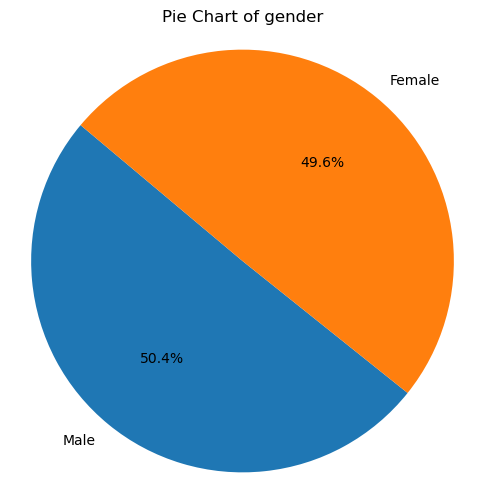

In [879]:
def draw_pie(categorical_var):
    plt.figure(figsize=(6, 6))
    value_counts = dating_df_subject[categorical_var].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.axis('equal') 
    plt.title(f'Pie Chart of {categorical_var}')
    plt.show()

draw_pie("gender")

We were happy to obserse that after removing all the missing values, the number of female and male participants could still reach a balance. Neither group was underrepresented, so we should be relatively confident in our future analysis in terms of gender differences. 

#### Age distribution of participants

In [880]:
print(dating_df_subject[["age"]].describe())

              age
count  397.000000
mean    26.158690
std      3.555122
min     18.000000
25%     23.000000
50%     26.000000
75%     28.000000
max     42.000000


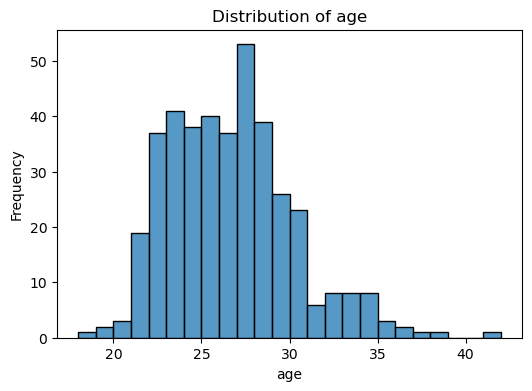

In [881]:
def draw_hist(numerical_var, bin_width):
    plt.figure(figsize = (6, 4))
    sns.histplot(data = dating_df_subject, x = numerical_var, binwidth = bin_width)
    plt.title(f'Distribution of {numerical_var}')
    plt.xlabel(numerical_var)
    plt.ylabel('Frequency')
    plt.show()

draw_hist("age", 1)

The mean age of participants was 26.2. The minimum age was 18, and the maximum age was 42. And from the histogram we could tell there were less observations for subjects aged below 20 or above 35. This implis our regression model might not be generalizable to these populations.

#### Fields the subjects studied

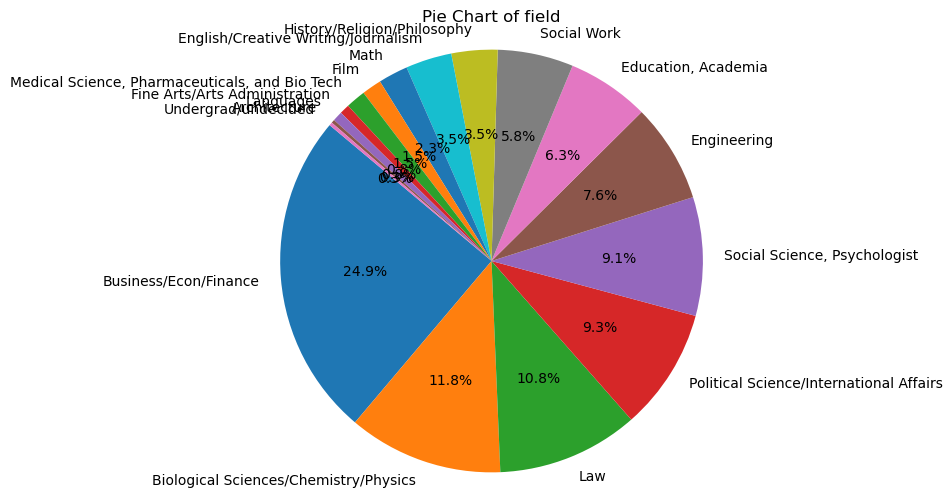

In [882]:
draw_pie("field")

The problem of the data regarding participants' fields here was quite obvious. About 1/4 of the students were in Business/Econ/Finance-related fields. However, majors like Fine Arts/Arts Administration were underrepresented. Although we could use field as a predictor, this would not solve the problem with the data itself. Because we could not be confident in whether participants majoring in Fine Arts/Arts Administration could represent the whole population of students majoring in Fine Arts/Arts Administration – we just did not have enough data.

#### Distribution of race

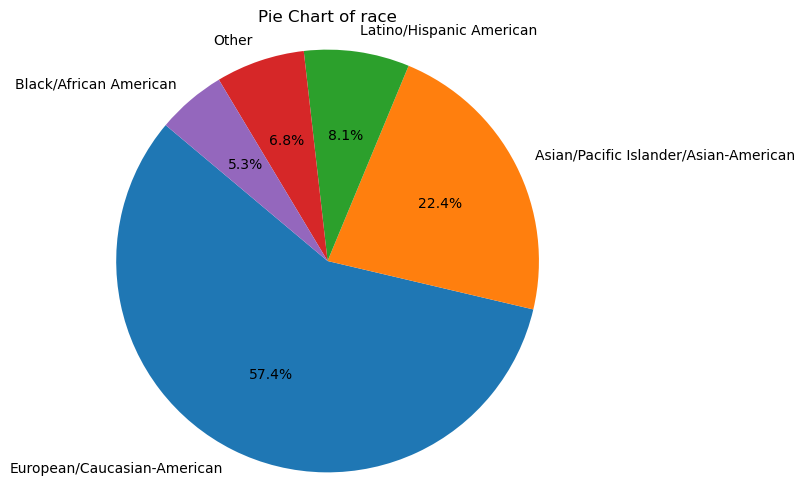

In [883]:
draw_pie("race")

Same problem here. Black/African American, Latino/Hispanic American, and international students were underrepresented compared to European/Caucasian-American and Asian/Pacific Islander/Asian American participants. This does not necessarily imply the data set is bad. Instead, doing this kind of descriptive statistics enables us to acknowledge the potential lack of generalizability of the models we make for the next phase to certain populations.

#### Self-ratings on five attributes

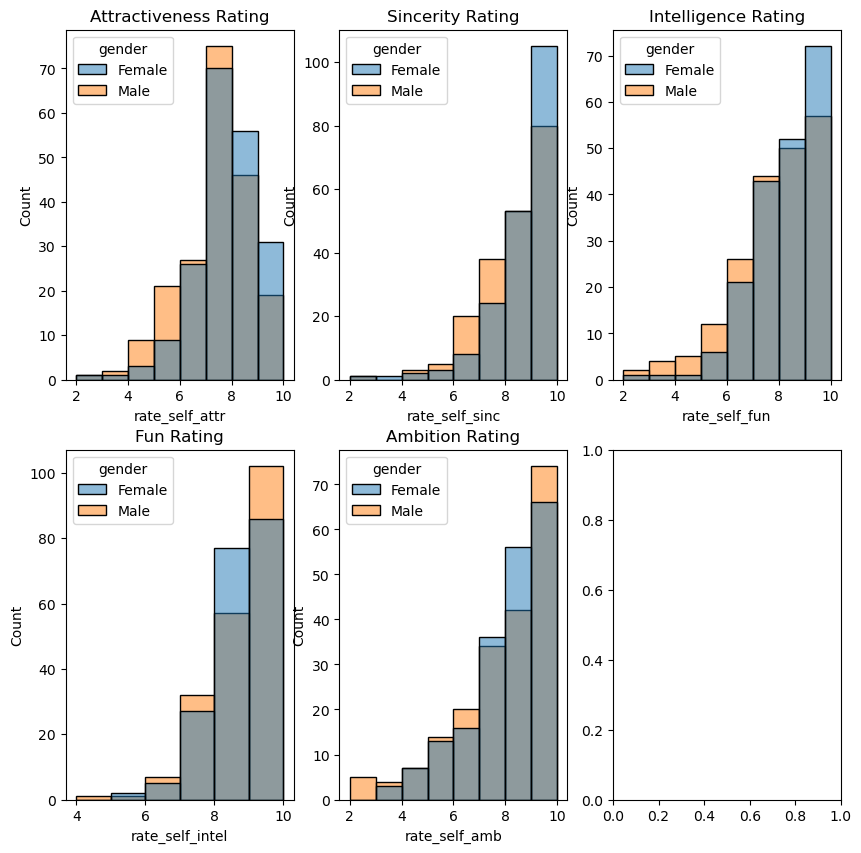

In [903]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10,10))
def draw_hist(numerical_var, bin_width, ax):
    sns.histplot(data = dating_df_subject, x = numerical_var, binwidth = bin_width, hue = "gender", ax = ax)

axs[0][0].set_title("Attractiveness Rating")
axs[0][1].set_title("Sincerity Rating"     )
axs[0][2].set_title("Intelligence Rating"  )
axs[1][0].set_title("Fun Rating"           )
axs[1][1].set_title("Ambition Rating"      )

draw_hist("rate_self_attr", 1, axs[0,0])
draw_hist("rate_self_sinc", 1, axs[0,1])
draw_hist("rate_self_fun", 1, axs[0,2])
draw_hist("rate_self_intel", 1, axs[1,0])
draw_hist("rate_self_amb", 1, axs[1,1])

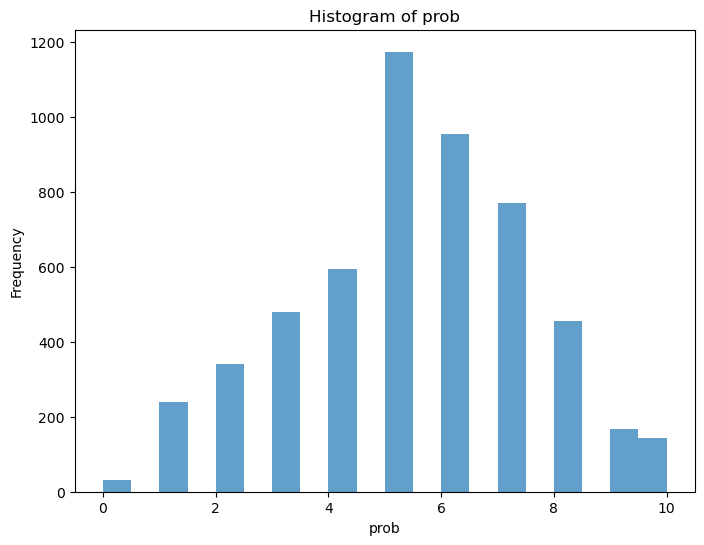

In [885]:
variable = 'prob'

plt.figure(figsize=(8, 6))
plt.hist(dating_df[variable].dropna(), bins=20,alpha=0.7)
plt.title(f'Histogram of {variable}')
plt.xlabel(variable)
plt.ylabel('Frequency')
plt.show()

In [886]:
columns_to_plot = ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]
labels = ["Attractive", "Sincere", "Intelligent", "Fun", "Ambitious", "Shared Interests"]

attribute_values = [dating_df[column].mean() for column in columns_to_plot]

x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, attribute_values, width=0.35, align='center', alpha=0.7, color='b', label='Attribute Values')

plt.xlabel('Attributes')
plt.xticks(x, labels, rotation=45)

plt.title('Comparison of Attributes')
plt.ylabel('Mean Attribute Value')

plt.legend()

plt.tight_layout()
plt.show()

KeyError: 'attr1_1'

In [ ]:
attribute = 'attr1_1'

female_data = dating_df[dating_df['gender'] == 0]
male_data = dating_df[dating_df['gender'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y=attribute, data=dating_df)
plt.title(f'Distribution of {attribute} by Gender')
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel(attribute)
plt.show()

In [ ]:
# F: two variable
# correlation

In [ ]:
# decision by gender
# rate yourself vs rate partner by gender
# rate partner vs decision by gender
# confidence(prob) vs decision by gender
# age_diff vs decision by gender

## Data Limitations
